# Explorative Data Analysis - CO2 Emissions

## Objective
In this notebook, the CO₂ emissions based on the fuel consumption of vehicles in Canada in 2020 are analyzed. The main objective is to identify the characteristics of vehicles that have the greatest impact on the vehicle emissions. Another objective is to identify correlations between features from which new information can be derived. 

## Data
The dataset used in this notebook is publisehd in: https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64#wb-auto-6


## Steps
The steps taken in this notebook:
- [Step 1](#step_1)
    : Importing Libraries and Dataset
- [Step 2](#step_2)
    : Dataset Informations + Data Quality
- [Step 3](#step_3)
    : CO2 Emissions and Rating    
- [Step 4](#step_4)
    : Car Manufacturers
- [Step 5](#step_5)
    : Vehicle Classes
- [Step 6](#step_6)
    : Number Cylinders and Engine Size   
- [Step 7](#step_7)
    : Fuel Type      
- [Step 8](#step_8)
    : Fuel Consumption          
- [Step 9](#step_9)
    : Machine Learning

## <a id="step_1">Step 1: Importing Libraries and Dataset</a>

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import colorcet as cc

# Preprocessing
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# ML Algorithm
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# nrows is set to 967, since the csv file includes a describtion of the columns below the actual table, making it necessary to specify nrows to only include the table 
df = pd.read_csv(os.path.join('Datasets','MY2020 Fuel Consumption Ratings.csv'), header=[0,1], nrows=967)

## <a id="step_2">Step 2: Dataset Informations  + Data Quality</a>

The dataset contains model-specific fuel consumption and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada 

To understand the dataset, the csv file contains following explainations:

#### Model

- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase

#### Transmission	

- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual
- 3 – 10 = Number of gears

#### Fuel type

- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas

#### Fuel consumption

City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)

#### CO2 emissions

the tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving

#### CO2 rating

the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best)

#### Smog rating

the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best)


In [3]:
df.head()

,Model,Make,Model,Vehicle Class,Engine Size,Cylinders,Transmission,Fuel,Fuel Consumption,Unnamed: 9_level_0,...,Unnamed: 211_level_0,Unnamed: 212_level_0,Unnamed: 213_level_0,Unnamed: 214_level_0,Unnamed: 215_level_0,Unnamed: 216_level_0,Unnamed: 217_level_0,Unnamed: 218_level_0,Unnamed: 219_level_0,Unnamed: 220_level_0
,Year,Unnamed: 1_level_1,Unnamed: 2_level_1,Unnamed: 3_level_1,(L),Unnamed: 5_level_1,Unnamed: 6_level_1,Type,City (L/100 km),Hwy (L/100 km),...,Unnamed: 211_level_1,Unnamed: 212_level_1,Unnamed: 213_level_1,Unnamed: 214_level_1,Unnamed: 215_level_1,Unnamed: 216_level_1,Unnamed: 217_level_1,Unnamed: 218_level_1,Unnamed: 219_level_1,Unnamed: 220_level_1
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS9,Z,12.3,9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6,AS9,Z,12.2,9.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,Acura,MDX Hybrid AWD,SUV: Small,3.0,6,AM7,Z,9.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,Acura,RDX AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains a lot of completely empty columns, so at first, all columns that contain not a single value are dropped
Further, the second row filled the headers with unnecessary information, which will be renamed

In [4]:
df = df.dropna(axis=1, how='all')

cols_level0 = df.columns.get_level_values(level=0).str.replace('Unnamed.*','Fuel Consumption')
cols_level1 = df.columns.get_level_values(level=1).str.replace('Unnamed.*','')
df.columns = [cols_level0,cols_level1]

In [5]:
# Flatten multiindex columns to simplify the analysis and avoid PerformanceWarnings
df.columns = [' '.join(col).strip() for col in df.columns.values]

In [6]:
df.head()

,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions (g/km),CO2 Rating,Smog Rating
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,199,6,3
1,2020,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS9,Z,12.3,9.2,10.9,26,254,4,3
2,2020,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6,AS9,Z,12.2,9.5,11.0,26,258,4,3
3,2020,Acura,MDX Hybrid AWD,SUV: Small,3.0,6,AM7,Z,9.1,9.0,9.0,31,210,5,3
4,2020,Acura,RDX AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Model Year                        967 non-null    int64  
 1   Make                              967 non-null    object 
 2   Model                             967 non-null    object 
 3   Vehicle Class                     967 non-null    object 
 4   Engine Size (L)                   967 non-null    float64
 5   Cylinders                         967 non-null    int64  
 6   Transmission                      967 non-null    object 
 7   Fuel Type                         967 non-null    object 
 8   Fuel Consumption City (L/100 km)  967 non-null    float64
 9   Fuel Consumption Hwy (L/100 km)   967 non-null    float64
 10  Fuel Consumption Comb (L/100 km)  967 non-null    float64
 11  Fuel Consumption Comb (mpg)       967 non-null    int64  
 12  CO2 Emis

As can be seen in the info, the dataset not a single NaN value in the remaining columns. So there is no need to apply any imputation methods to handle missing values.

Further, the dataset contains 5 categorical columns that need to be encoded when training most machine learning algorithms. The remaining columns are containing integers and floats. The variables that are suitable for use as target variables when training an algorithm, such as CO₂ emissions or smog, are available as integers.

In [8]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

print(f'Number of duplicated columns: {df.transpose().duplicated().sum()}')

Number of duplicated rows: 0
Number of duplicated columns: 0


There are no duplicated rows or columns in the dataset, that may need to be removed in the data preprocessing step before training a machine learning algorithm.

In [9]:
print((df.var() == 0))
print(f'Number of constant columns: {(df.var() == 0).sum()}')

Model Year                           True
Engine Size (L)                     False
Cylinders                           False
Fuel Consumption City (L/100 km)    False
Fuel Consumption Hwy (L/100 km)     False
Fuel Consumption Comb (L/100 km)    False
Fuel Consumption Comb (mpg)         False
CO2 Emissions (g/km)                False
CO2 Rating                          False
Smog Rating                         False
dtype: bool
Number of constant columns: 1


There is one constant columns in the dataset, which is the year.

In [10]:
# df.describe()

## <a id="step_3">Step 3: CO2 Emissions and Rating</a>

Let's understand more about the target variable, the CO2 emissions. Further the CO2 Rating, which should correlate negatively with the CO2 emissions, since the higher the emissions the lower the rating

In [11]:
df['CO2 Emissions (g/km)']

0      199
1      254
2      258
3      210
4      232
      ... 
962    219
963    232
964    240
965    232
966    248
Name: CO2 Emissions (g/km), Length: 967, dtype: int64

<AxesSubplot:xlabel='CO2 Emissions (g/km)', ylabel='Count'>

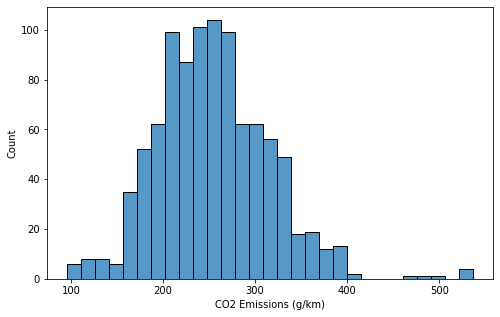

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='CO2 Emissions (g/km)')

In [13]:
df['CO2 Rating'].value_counts()

5     235
4     232
3     195
6     105
7      73
2      60
1      26
8      18
10     14
9       9
Name: CO2 Rating, dtype: int64

<AxesSubplot:xlabel='CO2 Rating', ylabel='Count'>

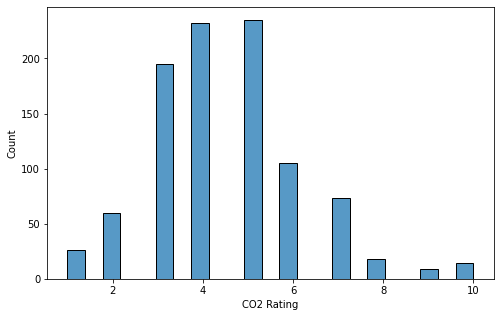

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='CO2 Rating')

In [15]:
corr = df[['CO2 Emissions (g/km)', 'CO2 Rating']].corr()
corr

,CO2 Emissions (g/km),CO2 Rating
CO2 Emissions (g/km),1.000000,-0.948933
CO2 Rating,-0.948933,1.000000


As the correlation matrix shows, the CO2 Rating has a strongly negative correlation with the CO2 emissions, as expected. Further, the distribution of ratings show that the CO2 Rating variable is highly imbalanced with strongly varying numbers of occurring frequencies

## <a id="step_4">Step 4: Car Manufacturers</a>

Which manufacturers are present in the dataset?

In [16]:
df['Make'].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'BMW',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'FIAT', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'MINI',
       'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Rolls-Royce', 'Subaru',
       'Toyota', 'Volkswagen', 'Volvo'], dtype=object)

Are there different amount of Models per manufacturer in the dataset? If so, which manufacturers are represented more/less often represented due to the amount of different vehicles included? 

Text(0, 0.5, 'Count')

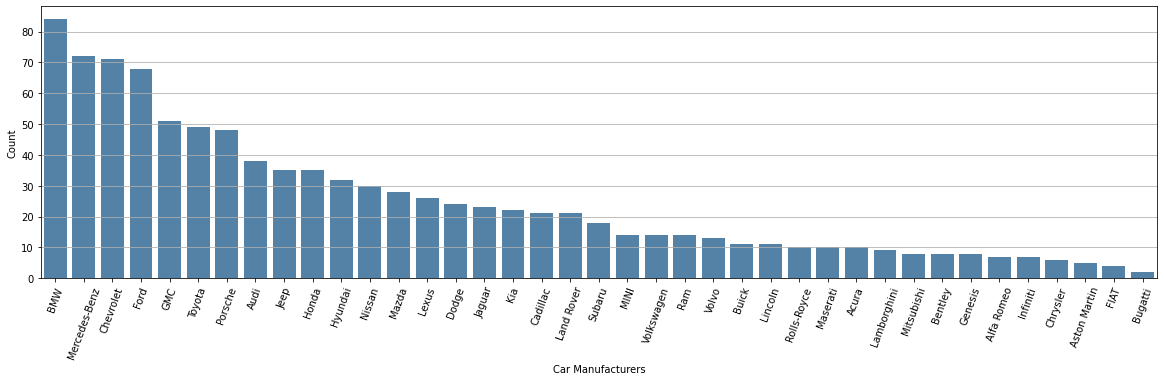

In [17]:
manufacturers_counts = df['Make'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_counts, x=manufacturers_counts['index'], y=manufacturers_counts[manufacturers_counts.columns[1]], color='steelblue')
plt.xlabel('Car Manufacturers')
plt.ylabel('Count')

#### Average CO2 emissions per manufacturer 

Text(0.5, 0, 'Car Manufacturers')

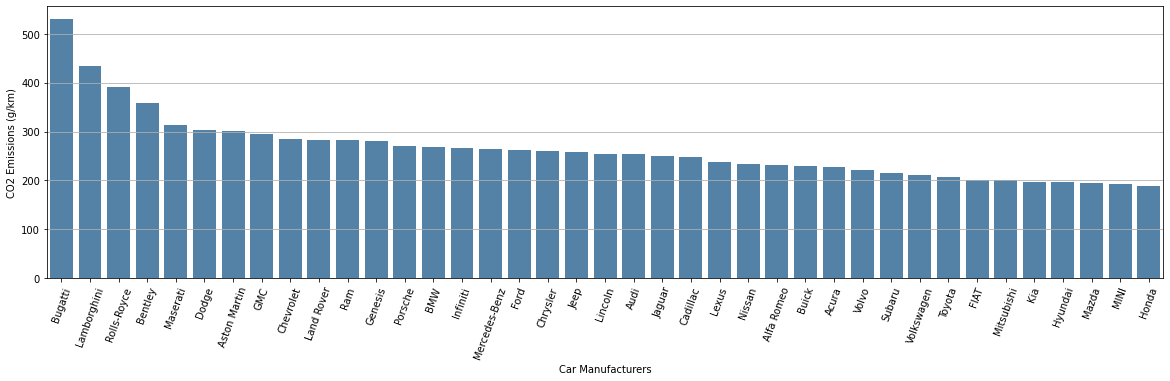

In [18]:
manufacturers_CO2 = df.groupby('Make').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_CO2, x=manufacturers_CO2['Make'], y=manufacturers_CO2['CO2 Emissions (g/km)'], color='steelblue')
plt.xlabel('Car Manufacturers')

On average, the vehicles by the car manufacturers 'Bugatti', 'Lamborghini' and 'Rolls-Royce' emit the most CO2 (g/km). That is expected since Bugatti and Lamborghini are super sportscar producer and rolls royce also mostly has very heavy cars with a lot of power. Let's check for these three manufacturers the number of cylinders and the engine sizes in relation to the other manufacturers

<AxesSubplot:xlabel='Cylinders', ylabel='Engine Size (L)'>

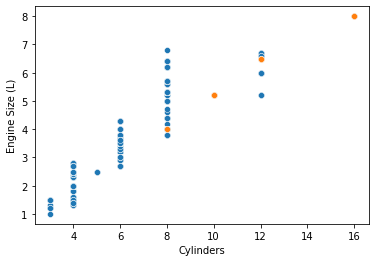

<Figure size 1440x360 with 0 Axes>

In [19]:
fig, ax = plt.subplots()
plt.figure(figsize=(20,5))
sns.scatterplot(data=df, x='Cylinders', y='Engine Size (L)', ax=ax)
sns.scatterplot(data=df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")], x='Cylinders', y='Engine Size (L)', ax=ax)

In [20]:
df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")][df['Cylinders'] == 8]

C:\Users\Johannes\AppData\Local\Temp/ipykernel_18548/42329695.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")][df['Cylinders'] == 8]


,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions (g/km),CO2 Rating,Smog Rating
580,2020,Lamborghini,Urus,SUV: Standard,4.0,8,AS8,Z,19.2,14.1,16.9,17,384,1,3


The models of these manufacturers are in the higher spectrums of the cylinder numbers and engine sizes, although one model (8 Cylinders and 4L Engine Size) is in the midfield of the data. This is the SUV Lamborghini Urus, which has the lowest possible CO2 rating.

Let's check the disitribution of CO2 emissions of the different manufacturers

Text(0.5, 0, 'Car Manufacturers')

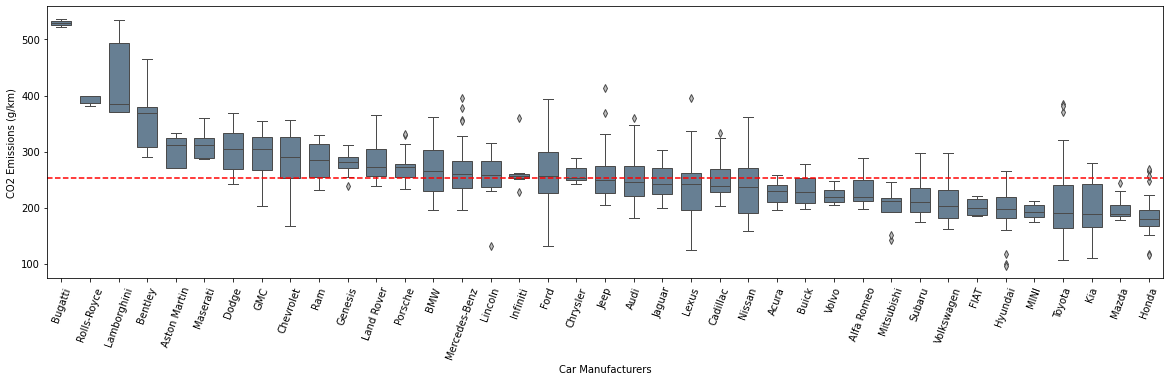

In [21]:
manufacturers_order = df.groupby('Make').median()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)['Make'].values
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')
sns.boxplot(data=df, x=df['Make'], y=df['CO2 Emissions (g/km)'], color='steelblue', order=manufacturers_order, width=0.7, linewidth=1, saturation=0.4, flierprops=flierprops)
plt.axhline(df['CO2 Emissions (g/km)'].median(),color='r', linestyle='dashed')
plt.xlabel('Car Manufacturers')

 ## <a id="step_5">Step 5: Vehicle Classes</a>

Which vehicle classes are present in the dataset?

In [22]:
df['Vehicle Class'].unique()

array(['Compact', 'SUV: Small', 'Mid-size', 'Two-seater', 'Minicompact',
       'Subcompact', 'Station wagon: Small', 'Station wagon: Mid-size',
       'Full-size', 'SUV: Standard', 'Pickup truck: Small',
       'Pickup truck: Standard', 'Minivan', 'Van: Passenger',
       'Special purpose vehicle'], dtype=object)

Are there different amount of vehicle classes in the dataset? If so, which classes are represented more/less often represented due to the amount of different vehicles included? 

Text(0, 0.5, 'Count')

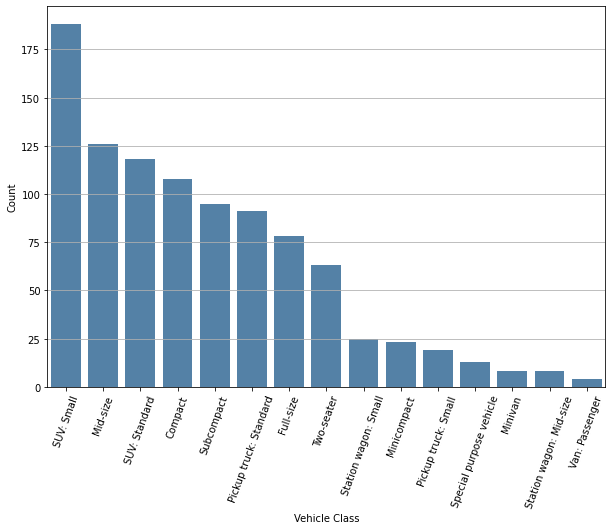

In [23]:
vehicleclass_counts = df['Vehicle Class'].value_counts().reset_index(drop=False)
plt.figure(figsize=(10,7))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_counts, x=vehicleclass_counts['index'], y=vehicleclass_counts[vehicleclass_counts.columns[1]], color='steelblue')
plt.xlabel('Vehicle Class')
plt.ylabel('Count')

#### Average CO2 emissions per vehicle class 

Text(0.5, 0, 'Vehicle Class')

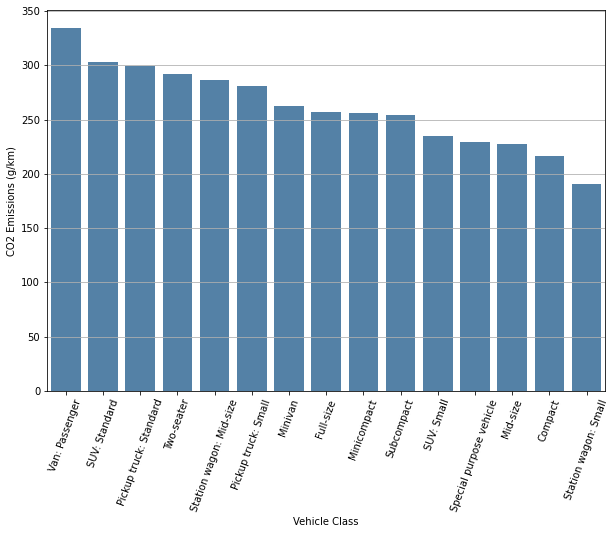

In [24]:
vehicleclass_CO2 = df.groupby('Vehicle Class').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(10,7))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_CO2, x=vehicleclass_CO2['Vehicle Class'], y=vehicleclass_CO2['CO2 Emissions (g/km)'], color='steelblue')
plt.xlabel('Vehicle Class')

#### Vehicle Classes of manufacturers

In [25]:
vehicleclasses_per_manufacturer = {}
for manufacturer in df['Make'].unique():
    unique_vehicleclasses = df[df['Make']==manufacturer]['Vehicle Class'].unique()
    vehicleclasses_per_manufacturer[manufacturer] = list(unique_vehicleclasses)

In [26]:
df_vehicleclasses_per_manufacturer = pd.DataFrame(columns=df['Vehicle Class'].unique())
for key, value in vehicleclasses_per_manufacturer.items():
    vehicleclasses_row = [1 if class_ in value else 0 for class_ in df['Vehicle Class'].unique()]
    df_vehicleclasses_per_manufacturer.loc[key] = vehicleclasses_row
df_vehicleclasses_per_manufacturer = df_vehicleclasses_per_manufacturer.astype(int)

Text(191.1923076923077, 0.5, 'Car Manufacturer')

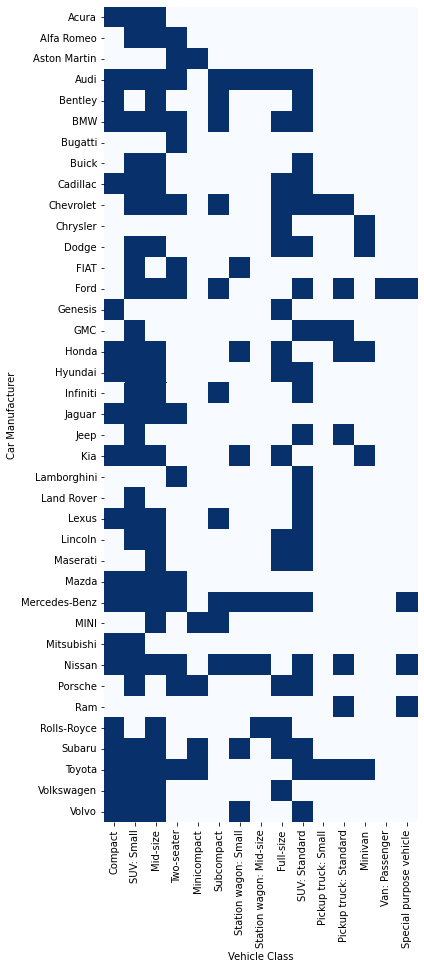

In [27]:
plt.figure(figsize=(10,15))
sns.heatmap(df_vehicleclasses_per_manufacturer, cmap="Blues", cbar=False, square=True)
plt.xlabel('Vehicle Class')
plt.ylabel('Car Manufacturer')

## <a id="step_6">Step 6: Number Cylinders and Engine Size</a>

In [28]:
df['Cylinders'].unique()

array([ 4,  6,  8, 12, 10,  5, 16,  3], dtype=int64)

Text(0, 0.5, 'Count')

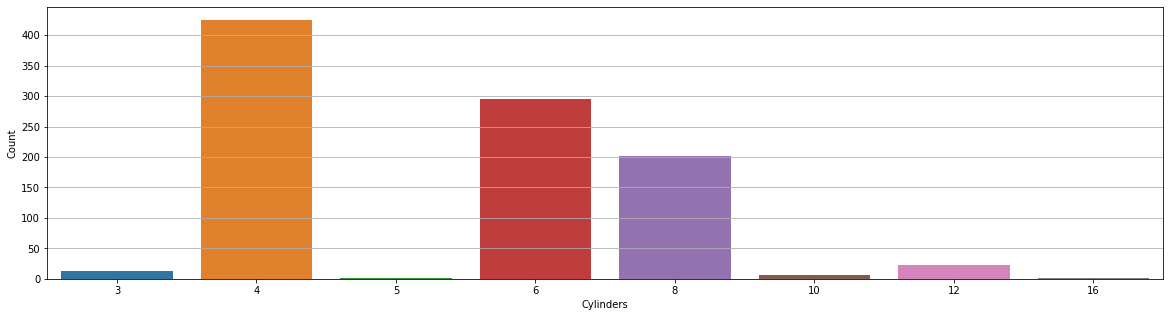

In [29]:
cylinders_counts = df['Cylinders'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()

sns.barplot(data=cylinders_counts, x=cylinders_counts['index'], y=cylinders_counts[cylinders_counts.columns[1]])
plt.xlabel('Cylinders')
plt.ylabel('Count')

Most vehicles in the dataset have 4 Cylinders, followed by 6 and 8 Cylinders. 

<AxesSubplot:xlabel='Cylinders', ylabel='CO2 Emissions (g/km)'>

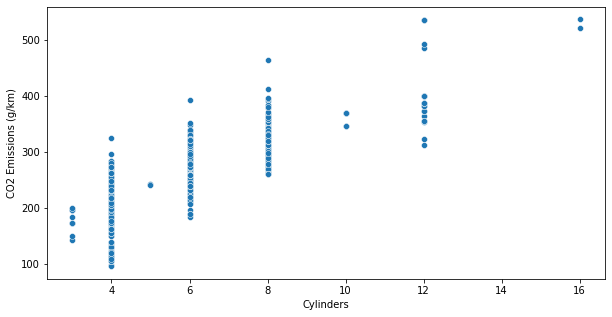

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Cylinders', y='CO2 Emissions (g/km)')

In [31]:
df['Engine Size (L)'].unique()

array([2.4, 3.5, 3. , 2. , 1.8, 2.9, 4. , 5.2, 2.5, 6. , 6.8, 4.4, 6.6,
       8. , 3.6, 1.4, 1.2, 1.3, 2.7, 4.2, 6.2, 2.8, 1.5, 4.3, 5.3, 5.7,
       6.4, 1. , 2.3, 3.3, 5. , 3.8, 1.6, 5.6, 3.2, 6.5, 4.6, 3.4, 3.7,
       4.7, 6.7])

Text(0, 0.5, 'Count')

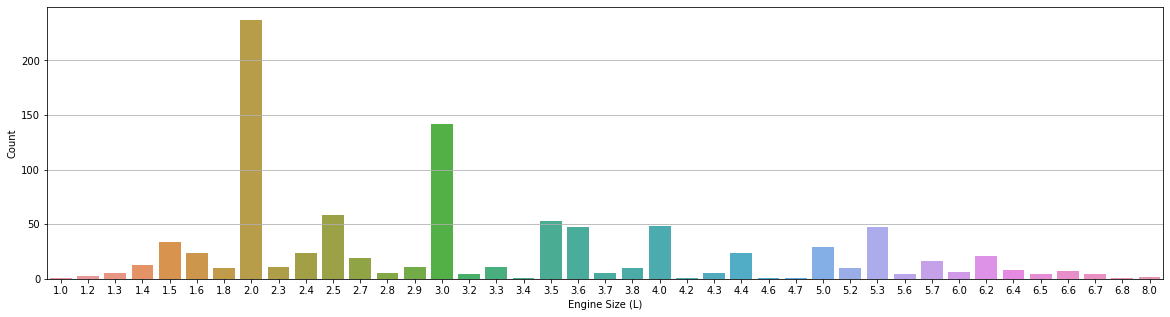

In [32]:
enginesize_counts = df['Engine Size (L)'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()
sns.barplot(data=enginesize_counts, x=enginesize_counts['index'], y=enginesize_counts[enginesize_counts.columns[1]])
plt.xlabel('Engine Size (L)')
plt.ylabel('Count')

<AxesSubplot:xlabel='Engine Size (L)', ylabel='CO2 Emissions (g/km)'>

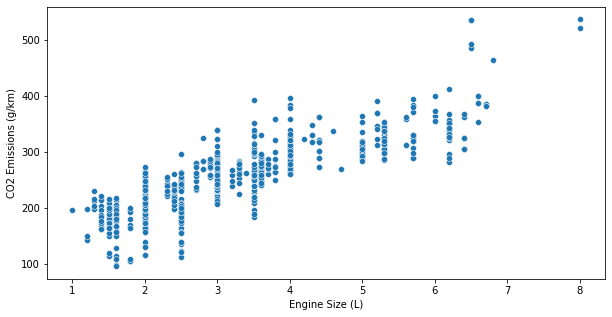

In [33]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Engine Size (L)', y='CO2 Emissions (g/km)')

## <a id="step_7">Step 7: Fuel Type</a>

In [34]:
df['Fuel Type'].unique()

array(['Z', 'X', 'D', 'E'], dtype=object)

As mentioned in the description, the fuel types included are:
- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas

Which means that there is no vehicle powered by natural gas in the dataset

Text(0, 0.5, 'Count')

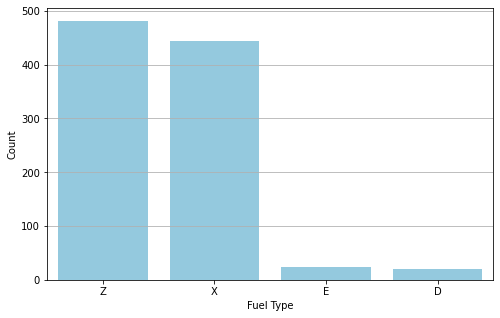

In [35]:
fueltype_counts = df['Fuel Type'].value_counts().reset_index(drop=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_counts, x=fueltype_counts['index'], y=fueltype_counts[fueltype_counts.columns[1]], color='skyblue')
plt.xlabel('Fuel Type')
plt.ylabel('Count')

In [36]:
df[df["Fuel Type"].str.contains("E|D")]['Make'].value_counts()

Ford          14
Chevrolet     12
GMC           11
Land Rover     3
Ram            2
Jeep           1
Name: Make, dtype: int64

There are just a few vehicles powered by Diesel and Ethanol. These are also for the largest part cars made by american car manufacturers like Ford, Chevrolet, GMC and RAM. 

<AxesSubplot:xlabel='Fuel Type', ylabel='CO2 Emissions (g/km)'>

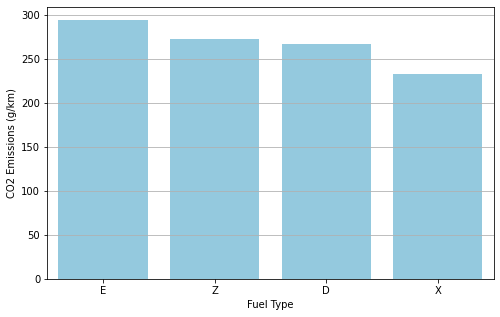

In [37]:
fueltype_CO2 = df.groupby('Fuel Type').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_CO2, x=fueltype_CO2['Fuel Type'], y=fueltype_CO2['CO2 Emissions (g/km)'], color='skyblue')

In [38]:
df[df["Fuel Type"].str.contains("E")]['Vehicle Class'].value_counts()

Pickup truck: Standard     10
SUV: Standard               8
Van: Passenger              2
Special purpose vehicle     2
Full-size                   1
Name: Vehicle Class, dtype: int64

Though ethanol and premium gasoline on average have the highest CO2 emissions, the vehicles present in the dataset that are powered by ethanol are all big, heavy cars like standard sized pickup trucks, SUVs, Vans, etc., which may distort the results shown in the graph 

<AxesSubplot:xlabel='Fuel Type', ylabel='CO2 Emissions (g/km)'>

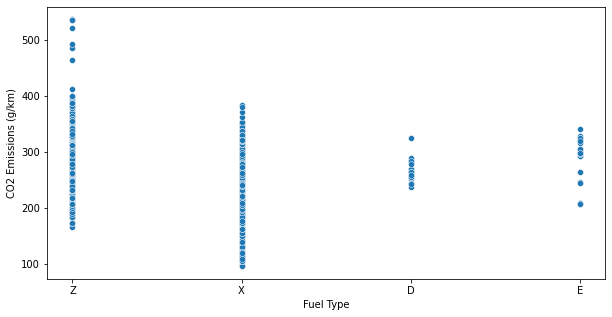

In [39]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Type', y='CO2 Emissions (g/km)')

Check correlation between the features of the dataset and the fuel consumption and CO2 emissions

<AxesSubplot:>

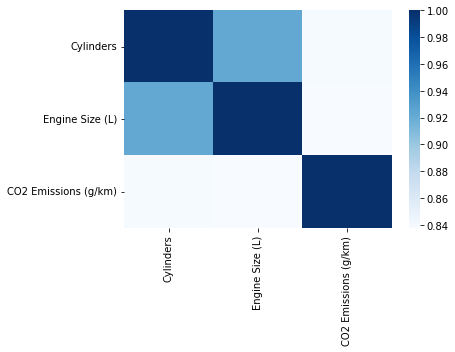

In [40]:
corr = df[['Cylinders', 'Engine Size (L)', 'CO2 Emissions (g/km)']].corr()
sns.heatmap(corr, cmap="Blues")

The Cylinders and Engine Size have a relatively high correlation with the CO2 emissions (above 0.84)

## <a id="step_8">Step 8: Fuel Consumption</a>

<AxesSubplot:>

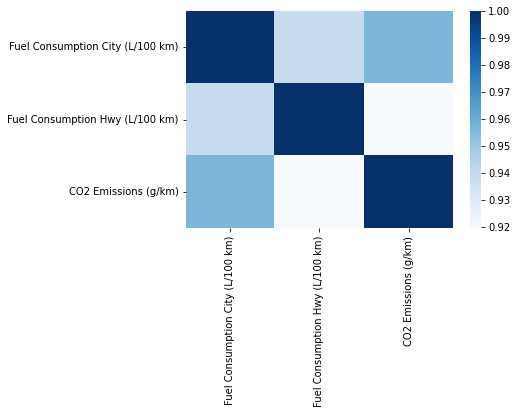

In [41]:
corr = df[['Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'CO2 Emissions (g/km)']].corr()
sns.heatmap(corr, cmap="Blues")

For the fuel consumption in the city and on the highway, the fuel consumption in the city has a higher correlation coefficient with the the CO2 emissions than the consumption on the highway. That is probably due to higher efficiency of the vehicles at higher speeds. Though both features have a very strong correlation due to a correlation coefficent above 0.92, which is even higher than the previous evaluated correlations including the number of cylinders and the engine size.
To get an idea of the relationship of the fuel consumption and the CO2 emissions we can look at the distribution. 

<AxesSubplot:xlabel='Fuel Consumption City (L/100 km)', ylabel='CO2 Emissions (g/km)'>

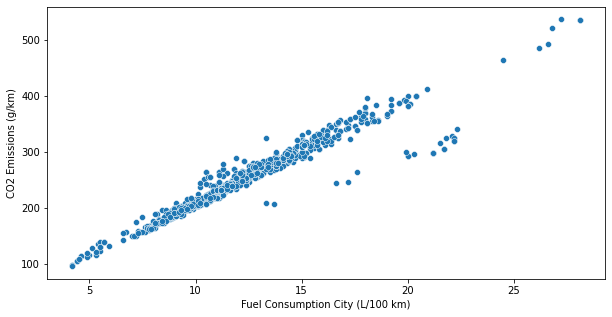

In [42]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption City (L/100 km)', y='CO2 Emissions (g/km)')

<AxesSubplot:xlabel='Fuel Consumption Hwy (L/100 km)', ylabel='CO2 Emissions (g/km)'>

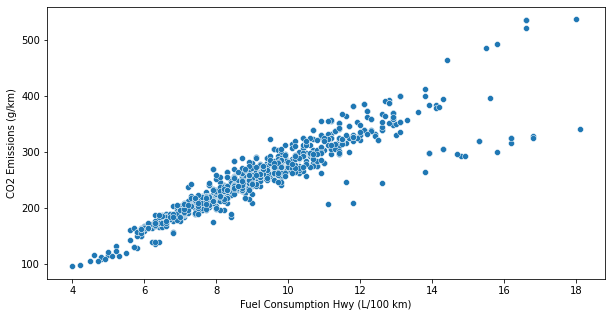

In [43]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption Hwy (L/100 km)', y='CO2 Emissions (g/km)')

<AxesSubplot:xlabel='Fuel Consumption Comb (L/100 km)', ylabel='CO2 Emissions (g/km)'>

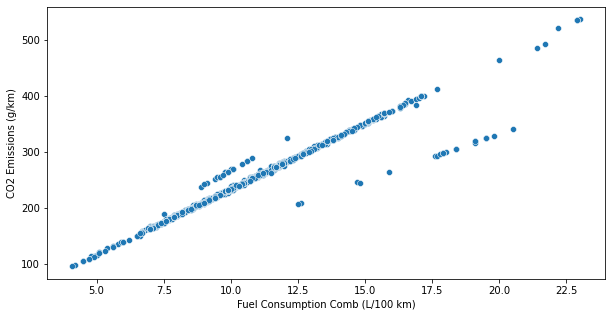

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)')

As the correlation matrix implies, the scatterplots show the strong relationship of the fuel consumption and the CO2 emissions. However, there are some outliers that distort the graph, as seen in the last graph. Let's check where the points come from. 

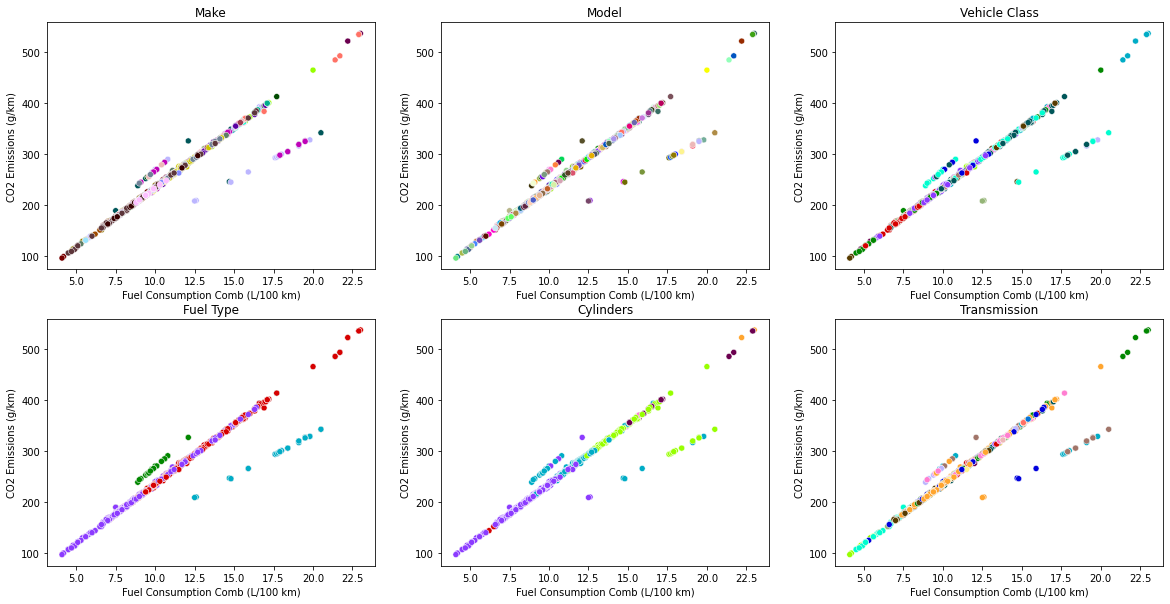

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
cols = ['Make', 'Model', 'Vehicle Class', 'Engine Size (L)', 'Cylinders', 'Transmission', 'Fuel Type']
nrow = 0
ncol = 0 
for col in cols:
    if ncol <=2:
        sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(cc.glasbey, n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1
    else:
        nrow = 1
        ncol = 0
        sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(cc.glasbey, n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1

So especially the Fuel Type indicates a relationship of these outliers. We already discovered, that some fuel types like ethanol distort the data by having a very small number of samples and some information that might be important, like the weight of the car, is missing.

<AxesSubplot:xlabel='Fuel Consumption Comb (L/100 km)', ylabel='CO2 Emissions (g/km)'>

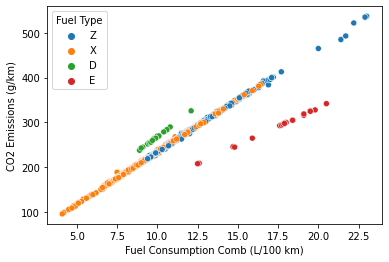

In [46]:
sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)', hue='Fuel Type')

So, as expected, the fuel types that form the outliers are the two fuel types, namely ethanol and diesel, that have a comparartively small number of samples.

## <a id="step_9">Step 9: Machine Learning</a>

### Data Preprocessing

As shown in Step 2, the dataset contains no missing values that may need to be imputed. Further, the dataset contains no duplicated columns or rows to be deleted or otherwise handled. However, the dataset contains 5 categorical columns that need to be encoded when using machine learning algorithms included in the scikit-learn library as well as a constant column, that does not contain any information an algorithm is able to utilize.

In [47]:
# First, exclude the target variable from the rest of the dataset. Since this dataset has 3 variables that may be used as a target variable for a machine learning algorithm, each will be excluded
X = df.iloc[:,:-3]

In [48]:
# Drop constant columns from the dataset.
print(f'Number of columns before: {len(X.columns)}')
X = X.loc[:, (X != X.iloc[0]).any()]
print(f'Number of columns after: {len(X.columns)}')

Number of columns before: 12
Number of columns after: 11


Then, the categorical columns have to be encoded. There are many encoding strategies that may be used, each with its own advantages and disadvantages. We first will try a very straight forwared encoding strategy called ordinal encoding. Here, every unique value in a categorical column will be assigned a integer that replaces the categorical value. The numbers typically start with 0 or 1 and increment for each additinal unique value in the column. Downside to using this strategy is the implementation of an order of the resulting numerical values.

In [49]:
ordinal_encoder = OrdinalEncoder(return_df=True)
print('Number of categorical columns before:', (X.dtypes == 'object').sum())
X_ordinal_encoded = ordinal_encoder.fit_transform(X)
print('Number of categorical columns after:', (X_ordinal_encoded.dtypes == 'object').sum())

Number of categorical columns before: 5
Number of categorical columns after: 0


Further, we can use a scaler to rescale the columns in the dataset so all columns are on the same scale as well as normalize the columns in the dataset so the distribution in the columns closely resemble a normal distribution instead of being skewed.

In [50]:
standard_scaler = StandardScaler()

cols_before = X_ordinal_encoded.columns
X_ordinal_encoded = pd.DataFrame(data=standard_scaler.fit_transform(X_ordinal_encoded), columns = cols_before)

In [51]:
cols_before = X_ordinal_encoded.columns
X_ordinal_encoded = pd.DataFrame(data=power_transform(X_ordinal_encoded, method='yeo-johnson'), columns = cols_before)

##### Let's use the CO2 emissions as the target variable, which is a continuous variable, resulting in the use of regression models

In [52]:
# Specify target variable
y = df['CO2 Emissions (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded, y, test_size=0.3)

DecisionTree

In [53]:
decisiontree_model_regression = DecisionTreeRegressor()

decisiontree_model_regression.fit(X_train, y_train)
cvs = -cross_val_score(decisiontree_model_regression, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print(f'Cross Validation RMSE Score: {cvs}')

y_pred = decisiontree_model_regression.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
max_e = max_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Max Error: {max_e}')

Cross Validation RMSE Score: 5.20873589665405
Root Mean Squared Error: 7.156329954609694
Mean Squared Error: 51.213058419243985
Mean Absolute Error: 2.70446735395189
Max Error: 72.0


RandomForest

In [54]:
randomforest_model_regression = RandomForestRegressor()

randomforest_model_regression.fit(X_train, y_train)
cvs = -cross_val_score(randomforest_model_regression, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print(f'Cross Validation RMSE Score: {cvs}')

y_pred = randomforest_model_regression.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
max_e = max_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Max Error: {max_e}')

Cross Validation RMSE Score: 5.617419962829597
Root Mean Squared Error: 7.784478432583262
Mean Squared Error: 60.59810446735395
Mean Absolute Error: 2.847835051546393
Max Error: 58.110000000000014


The closer the Error to 0, the better, with a perfect score when an error of 0 is achieved. So the RMSE and MAE show already very good results. Let's check the scores for a classification task.

##### Let's use the CO2 rating as the target variable, which is a discrete variable, resulting in the use of classification models

In [55]:
# Specify target variable
y = df['CO2 Rating']
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded, y, test_size=0.3, stratify=y)

In [56]:
df['CO2 Rating'].unique()

array([ 6,  4,  5,  3,  7,  2,  1,  9, 10,  8], dtype=int64)

Since the CO2 Rating has more than two classes and we therefore need a multiclass prediction model, we need to set a parameter for the scoring metrics. Here we set the average parameter to 'macro', so the metrics are calculated for each class and then an unweighted mean is identified. This method is highly sensitive to unbalanced data, which the CO2 Rating is, as shown in Step 3

DecisionTree

In [57]:
decisiontree_model_classification = DecisionTreeClassifier()

decisiontree_model_classification.fit(X_train, y_train)
cvs = cross_val_score(decisiontree_model_classification, X_train, y_train, cv = 5, scoring = 'f1_macro').mean()
print(f'Cross Validation F1 Score: {cvs}')

y_pred = decisiontree_model_classification.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Cross Validation F1 Score: 0.9368880185611138
Accuracy: 0.9621993127147767
Precision: 0.9079341736694678
Recall: 0.9192327720819007
F1 Score: 0.9119483232685777


RandomForest

In [63]:
randomforest_model_classification = RandomForestClassifier()

randomforest_model_classification.fit(X_train, y_train)
cvs = cross_val_score(randomforest_model_classification, X_train, y_train, cv = 5, scoring = 'f1_macro').mean()
print(f'Cross Validation F1 Score: {cvs}')

y_pred = randomforest_model_classification.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Cross Validation F1 Score: 0.9325844481740819
Accuracy: 0.9690721649484536
Precision: 0.9628754882234585
Recall: 0.9490646911773671
F1 Score: 0.9509424752290643


The resulting test scores show already very good results. However, the RandomForest model shows that the training scores are lower than the test scores, so we might expect the model to underfit the data. Let's try different parameter settings for the RandomForest model.

In [69]:
randomforest_model_classification = RandomForestClassifier()

grid = {'n_estimators': randint.rvs(50, 400, size=10),
        'min_samples_leaf' : randint.rvs(1, 12, size=10),
        'min_samples_split' : randint.rvs(2, 10, size=10)}
randomforest_rscv = RandomizedSearchCV(randomforest_model_classification, param_distributions=grid, scoring='f1_macro', cv=5)

randomforest_rscv.fit(X_train, y_train)

print(randomforest_rscv.best_params_)
print(randomforest_rscv.best_score_)

{'n_estimators': 209, 'min_samples_split': 2, 'min_samples_leaf': 3}
0.9221020026263791
